In [1]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [2]:
ts, dt = (30.0, 0.1)
def mass_spring_damper_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x0 = torch.normal(mean=10.0, std=3.0, size=(1,))
    v0 = torch.normal(mean=3.0, std=1.0, size=(1,))
    x, v = float(x0), float(v0)  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    trajectory = torch.tensor(trajectory)
    noise_std = 0.1 
    trajectory += torch.randn_like(trajectory) * noise_std
    return trajectory.clone().detach()

In [3]:
def mass_spring_damper_fixed_simulator(theta):
    m, k, b = theta
    steps = int(ts/dt)
    x, v = 3, 10  # Initial conditions
    force = np.cos(np.arange(steps) * dt * 10)
    trajectory = []

    for f in force:
        x_new = x + dt * v
        v_new = v + dt * (-k * x / m - b * v / m + f / m)
        x, v = x_new, v_new
        trajectory.append([x, v])

    return torch.tensor(trajectory)

In [4]:
true_parameter = torch.tensor([7.5, 3.0, 1.2])
x_observed = mass_spring_damper_fixed_simulator(true_parameter)

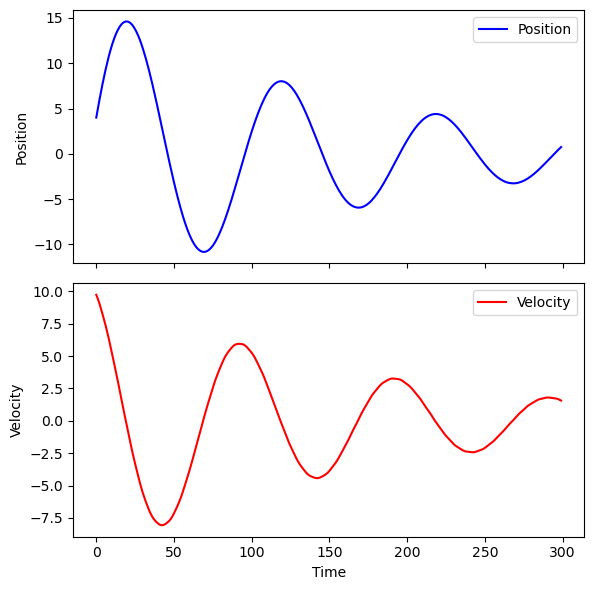

In [5]:
t = torch.arange(len(x_observed))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Position", color="b")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Velocity", color="r")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
dim = int(ts/dt) * 2
embedding_net = CNNEmbedding(
    input_shape=(dim, ), 
    output_dim=100,
    # out_channels_per_layer=[64, 128, 256],
    # num_conv_layers=3,
    # num_linear_layers=3,
    # num_linear_units=200,
)

In [7]:
prior = BoxUniform(low=torch.tensor([5.0, 2.0, 1.0]), 
                   high=torch.tensor([15.0, 7.0, 3.0]))

prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [8]:
simulator_wrapper = process_simulator(mass_spring_damper_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [9]:
neural_posterior = posterior_nn(model='maf', embedding_net=embedding_net)

In [ ]:
# inference = NPE(prior=prior, density_estimator=neural_posterior)
inference = NPE(prior=prior)

In [11]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
# Flatten the input tensor x
x_flattened = x.view(x.size(0), -1)
density_estimator = inference.append_simulations(theta, x_flattened).train()

 Neural network successfully converged after 198 epochs.

In [13]:
posterior = inference.build_posterior(density_estimator)

In [14]:
samples = posterior.sample((5000,), x=x_observed.flatten())

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

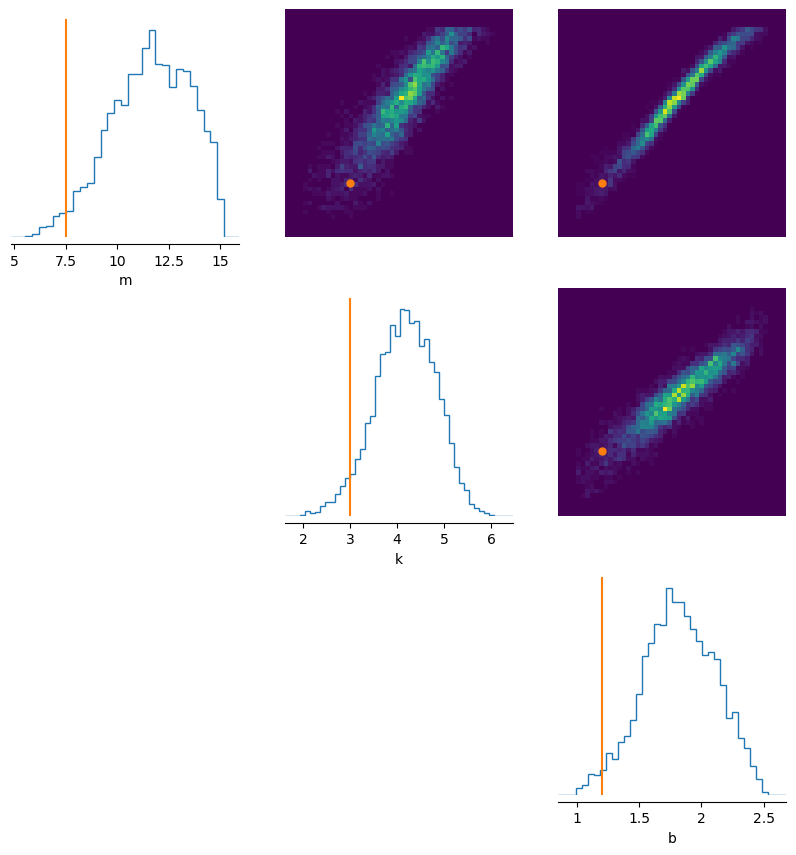

In [15]:
fig, ax = analysis.pairplot(
    samples,
    points=true_parameter.unsqueeze(0),
    labels=["m", "k", "b"], 
)

In [22]:
# Draw a sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=x_observed.flatten()).numpy()
print(posterior_sample)
# posterior_sample = np.array([[11.434443 ,  5.0334888,  2.0032296]])
# posterior_sample = np.array([[12.958532,   6.4162064,  2.6226623]])
x_posterior = mass_spring_damper_fixed_simulator(posterior_sample.squeeze())

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

[[8.945779  3.3713317 1.4893014]]


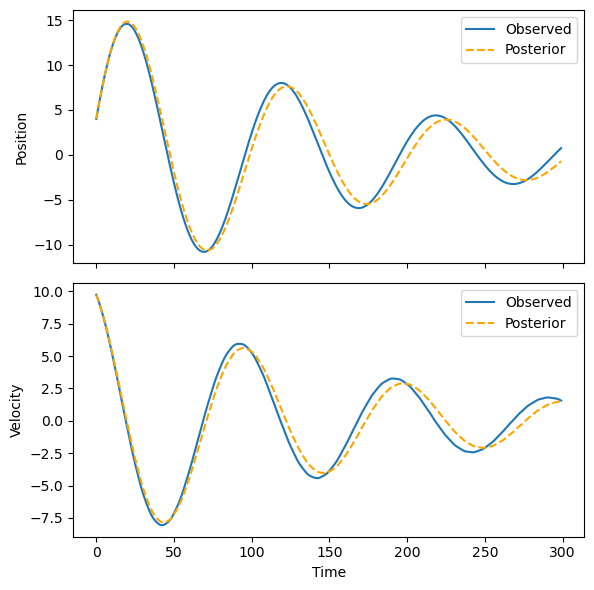

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# Plot first column
axes[0].plot(t, x_observed[:, 0], label="Observed")
axes[0].plot(t, x_posterior[:, 0], label="Posterior", linestyle='--' ,color="orange")
axes[0].set_ylabel("Position")
axes[0].legend()

# Plot second column
axes[1].plot(t, x_observed[:, 1], label="Observed")
axes[1].plot(t, x_posterior[:, 1], label="Posterior", linestyle='--' ,color="orange")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Velocity")
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
samples_np = samples.numpy()
df = pd.DataFrame(samples_np, columns=["m", "k", "b"])
df.to_csv("posterior_samples.csv", index=False)

In [19]:
from scipy.optimize import curve_fit

# Calculate summary statistics for the observed data
position_observed = x_observed[:, 0].numpy()
velocity_observed = x_observed[:, 1].numpy()

summary_statistics = {
    'position_mean': np.mean(position_observed),
    'position_std': np.std(position_observed),
    'position_max': np.max(position_observed),
    'position_min': np.min(position_observed),
    'velocity_mean': np.mean(velocity_observed),
    'velocity_std': np.std(velocity_observed),
    'velocity_max': np.max(velocity_observed),
    'velocity_min': np.min(velocity_observed)
}

print(summary_statistics)

{'position_mean': 0.7534302, 'position_std': 4.984053, 'position_max': 13.04932, 'position_min': -9.318452, 'velocity_mean': -0.10673899, 'velocity_std': 3.3764968, 'velocity_max': 9.66, 'velocity_min': -7.9200745}


In [20]:
# Define the exponential decay function
def exponential_decay(t, A, B, C):
    return A * np.exp(-B * t) + C

# Fit the exponential decay to the absolute value of the position data
popt, pcov = curve_fit(exponential_decay, t.numpy(), np.abs(position_observed))

# Extract the decay rate
decay_rate = popt[1]

print(f"Estimated decay rate: {decay_rate}")

Estimated decay rate: 0.009249263126595656


/tmp/ipykernel_42521/661279878.py:3: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * t) + C
